In [68]:
from sklearn.preprocessing import StandardScaler
import h5py
import os
from scipy.signal import resample


def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name


# Folder path and task types
train_path = 'data/Intra/train/'
test_path = 'data/Intra/test/'
task_types = {
    'rest': 0,
    'task_motor': 1,
    'task_story': 2,
    'task_working': 3
}

# all h5 files in the folder
file_names = [f for f in os.listdir(train_path) if f.endswith('.h5')]
file_names_testing = [f for f in os.listdir(test_path) if f.endswith('.h5')]


downsample_factor = 4  #



def downsample(normalized_data):
    # How to know that we're not having a negative impact on the accuracy
    # Every file corresponds to a duration of approximately 17.5 seconds.
    #  print(35624 / 2034) 

    original_sample_rate = 2034
    target_sample_rate = 100  # Choose your desired target sample rate

    # Calculate the new number of time points based on the target sample rate
    new_num_time_points = int(
        normalized_data.shape[1] * target_sample_rate / original_sample_rate)

    # Perform downsampling
    return resample(normalized_data, new_num_time_points, axis=1)


def get_data_and_labels(folder_path, file_names):
    all_data = []
    labels = []
    for filename in file_names:
        full_path = os.path.join(folder_path, filename)
        with h5py.File(full_path, 'r') as file:
            # Assuming 'dataset' is your key
            dataset_name = get_dataset_name(full_path)
            data = file.get(dataset_name)[()]
            # print(type(data))
            # print(data.shape)

            downsampled_data = data[:, ::downsample_factor]
            # print(data.shape)

            scaler = StandardScaler()

            X_scaled = scaler.fit_transform(
                downsampled_data.reshape(-1, downsampled_data.shape[-1])).reshape(downsampled_data.shape)
            # print('scaled', X_scaled.shape)

            # X_scaled = scaler.fit_transform(
            #     data.reshape(-1, data.shape[-1])).reshape(data.shape)

            all_data.append(X_scaled)

            # Extract task type and label
            if filename.startswith('task'):
                # Joins 'task' and the next word
                task_type = '_'.join(filename.split('_')[:2])
            else:
                task_type = filename.split('_')[0]
            # Default to -1 if task type not found
            label = task_types.get(task_type, -1)
            labels.append(label)
    return (all_data, labels)

# Question
2 types of classifications are performed. The first one is intra-subject classification, where deep learning is used to train and test models using the same subject(s). The second type, called cross-subject classification, happens when we train a model with a set of subjects, but test the model on new, unseen subjects.

**The goal will be to accurately classify whether the subject is in one of the following states: rest, math, memory, motor.**

# Data exploration / Preprocessing
Begin by exploring a few examples of the data. Visualize time-series data from individual sensors to get a sense of the patterns and variability

In [69]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

all_data, labels = get_data_and_labels(train_path, file_names)
all_test_data, test_labels = get_data_and_labels(test_path, file_names_testing)

all_data_concatenated = np.stack(all_data, axis=0)
print(all_data_concatenated.shape)
# print(all_data_concatenated)
one_hot_labels = to_categorical(labels, num_classes=4)
all_test_data_concatenated = np.stack(all_test_data, axis=0)
print(all_test_data_concatenated.shape)
one_hot_test_labels = to_categorical(test_labels, num_classes=4)
print(one_hot_labels.shape)
print(one_hot_test_labels.shape)


(32, 248, 8906)
(8, 248, 8906)
(32, 4)
(8, 4)


# Model Architecture:

Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs) are often used for time-series data like MEG.

The layers are as follows:

in summary, the model is a sequential neural network with two LSTM layers followed by dropout layers, and finally, a dense layer for classification with a softmax activation. This architecture is commonly used for sequence-based classification tasks. Adjustments to hidden_size, dropout, and other hyperparameters would affect the performance.

In [ ]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


def init_model(input_shape, hidden_size, dropout=0.2):
    model = Sequential([
        LSTM(hidden_size, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(hidden_size),
        Dropout(dropout),
        Dense(units=4, activation='softmax')
    ])
    return model


# input_shape is a tuple representing the shape of your input data, e.g., (sequence_length, input_features)
sequence_length = 248
input_features = 8906
input_shape = (sequence_length, input_features)
#  `hidden_size`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
hidden_size = 50
# `num_layers`: Number of LSTM layers in the network. Typically between 1-3
num_layers = 2
dropout = 0.2
model = init_model(input_shape=input_shape, hidden_size=hidden_size, dropout=dropout)
print(model.summary())

# Model Training:

Train your model using the training set. Monitor the training process for potential overfitting or underfitting. Adjust hyperparameters as needed.

data and training hyparameters
* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.

In [ ]:

from sklearn.model_selection import KFold
# training params

# loss and optimization functions
lr = 0.001

loss = 'categorical_crossentropy'
optimizer = 'adam'

# for logging
verbose = 0

# how many times the entire training dataset is passed forward and backward through the neural network
epochs = 15

# The dataset is split into 5 folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = []

cv_train_losses = []
cv_val_losses = []

for train_index, test_index in kf.split(all_data_concatenated):
    # Split data
    X_train, X_test = all_data_concatenated[train_index], all_data_concatenated[test_index]
    y_train, y_test = one_hot_labels[train_index], one_hot_labels[test_index]

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # The model is trained (fit) on the training data for a specified number of epochs and validated on the testing data in each epoch.
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=32, validation_data=(X_test, y_test), verbose = verbose)
           
    cv_train_losses.append(history.history['loss'])
    cv_val_losses.append(history.history['val_loss'])

    # The trained model is then evaluated on the overall test set (not just the current fold), and the accuracy score is appended to cv_scores.
    scores = model.evaluate(all_test_data_concatenated, one_hot_test_labels)
    cv_scores.append(scores[1])

# print(history.history)

# Calculate average performance across all folds
average_accuracy = np.mean(cv_scores)
print(f"Average Cross-Validation Accuracy: {average_accuracy}")

[1.36422193 1.33267105 1.20011699 1.13398135 1.05294609 1.02111268
 1.06915891 1.01662266 0.96697617 0.87392175 0.87369215 0.87466425
 0.8120712  0.76553226 0.75313538 0.76628965 0.88029802 0.72670549
 0.65961736 0.61875594 0.56879336 0.53847522 0.492957   0.43327522
 0.39665791 0.39611119 0.36167639 0.36554939 0.31184185 0.2891472
 0.24259184 0.32780364 0.551566   0.28666493 0.27024108 0.31405216
 0.19980726 0.20621952 0.20887426 0.16942483 0.15872806 0.14294514
 0.11877363 0.12772459 0.10677966 0.12657249 0.14968576 0.7096808
 0.45079663 0.32143432 0.15744294 0.12483008 0.12410969 0.1579939
 0.13128005 0.13933539 0.10370293 0.11062582 0.09413033 0.0893708
 0.09147809 0.06760231 0.05555348 0.26546657 0.05008951 0.27024093
 0.17915279 0.62324512 0.65383822 0.37786233 0.23389211 0.06105643
 0.0583244  0.06486736 0.07159686]


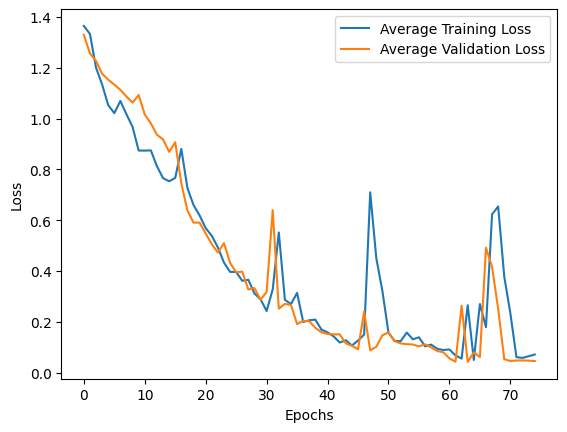

In [72]:
import numpy as np

# Plot average training and validation loss across all folds
# print(cv_train_losses.flatten())
# print(cv_val_losses.flatten())
# average_train_loss = np.mean(np.array(cv_train_losses), axis=0)
# average_val_loss = np.mean(np.array(cv_val_losses), axis=0)

cv_train_losses = np.array(cv_train_losses).flatten()
cv_val_losses = np.array(cv_val_losses).flatten()

print(cv_train_losses)

plt.plot(cv_train_losses, label='Average Training Loss')
plt.plot(cv_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inference/Predictions

Generate predictions for a random sample
(248, 8906)
1/1 [==============================] - 1s 793ms/step
[[0.9780181  0.0035813  0.01525224 0.00314838]]
Predicted Task Type: rest
True Task Type: rest


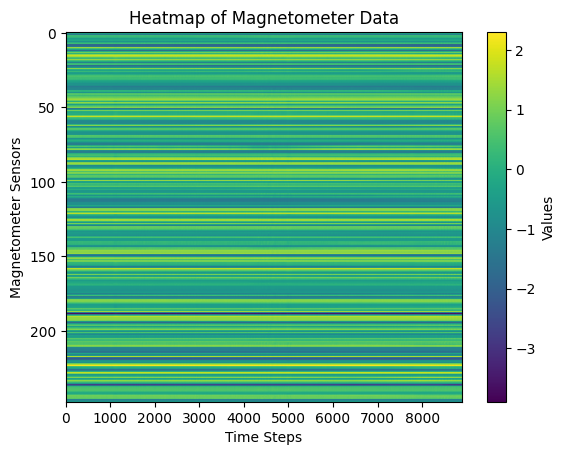

In [73]:
# Generate predictions (probabilities -- the output of the last layer)
print("Generate predictions for a random sample")

# Get a random index along the first axis
random_index = np.random.randint(all_test_data_concatenated.shape[0])

# Extract the random sample
# random_sample = all_test_data_concatenated[random_index, :, :]
# print(random_sample.shape)

random_sample = all_test_data_concatenated[random_index]
true_class_index = test_labels[random_index]
print(random_sample.shape)


predictions = model.predict(np.expand_dims(random_sample, axis=0))
print(predictions)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding task type
predicted_task_type = [
    key for key, value in task_types.items() if value == predicted_class_index][0]
true_task_type = [key for key, value in task_types.items()
                  if value == true_class_index][0]


print(f"Predicted Task Type: {predicted_task_type}")
print(f"True Task Type: {true_task_type}")

# matrix_data = np.squeeze(random_sample, axis=0)
plt.imshow(random_sample, aspect='auto', cmap='viridis')
plt.xlabel('Time Steps')
plt.ylabel('Magnetometer Sensors')
plt.title('Heatmap of Magnetometer Data')
plt.colorbar(label='Values')
plt.show()